In [48]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import cdist
import numpy as np
import scipy
import seaborn as sns
import pdb
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import norm
from scipy.stats import truncnorm
from sklearn.datasets import make_moons, make_circles
import time
from joblib import Parallel, delayed
import multiprocessing
from IPython.display import clear_output
from IPython.display import display
import sympy; sympy.init_printing()
%matplotlib inline

In [49]:
def display_matrix(m):
    display(sympy.Matrix(m))

In [50]:
## Function to solve dx/dt = f(x) where f is a neural net
## This example involves a neural net which takes in 2 inputs 
## and has two hidden layers of 10 nodes each, and outputs 2 values.
## The activation function is tanh
def neural_solve(t,w,b,init):
    """
    Arguments
    ==========
    t: (array) time grid on which we want the solution
    w: (list of arrays) a list containing weights for each layer of neural net
    b: (list of arrays) a list of vectors containing biases for each layer of neural net
    init: (array) array containing initial conditions for x_1,x_2
    """
    
    # set up neural net using parameters in w,b
    model = nn.Sequential(nn.Linear(4,10),
                          nn.Tanh(),
                          nn.Linear(10,4))
    model[0].weight.data = torch.from_numpy(w[0]).float()
    model[0].bias.data = torch.from_numpy(b[0].flatten()).float()
    model[2].weight.data = torch.from_numpy(w[1]).float()
    model[2].bias.data = torch.from_numpy(b[1].flatten()).float()
    
    # set up function for ODEs (ensure this is compatible with scipy.odeint)
    def f(y,t):
        # convert numpy array to torch tensor
        y = torch.from_numpy(y).float()
        
        # compute RHS by passing tensor y to neural net 'model'
        derivs = model(y)
        
        # return RHS, converting torch.tensor to numpy array
        return derivs.detach().numpy()
    
    # solve system using odeint
    soln = odeint(f,init,t)
    
    # return soln
    return soln

In [5]:
# t = np.linspace(0,1,20)
# np.random.seed(42)
# w = []
# w.append(norm.rvs(size=(10,4)))
# w.append(norm.rvs(size=(4,10)))
# b = []
# b.append(norm.rvs(size=(10,1)))
# b.append(norm.rvs(size=(4,1)))
# init = np.array([1,1,1,1])
# soln = neural_solve(t,w,b,init)

# fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,constrained_layout=True,figsize=(12,7))

# ax1.plot(t,soln[:,0])
# ax1.grid()
# ax1.set_xlabel('t')
# ax1.set_ylabel('x_1')

# ax2.plot(t,soln[:,1])
# ax2.grid()
# ax2.set_xlabel('t')
# ax2.set_ylabel('x_2')

# ax3.plot(t,soln[:,2])
# ax3.grid()
# ax3.set_xlabel('t')
# ax3.set_ylabel('x_3')

# ax4.plot(t,soln[:,3])
# ax4.grid()
# ax4.set_xlabel('t')
# ax4.set_ylabel('x_4')

# plt.show()

In [51]:
## code to generate random initial conditions and solve system on a time grid t
def noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w,b,mu_1=1,mu_2=1,mu_3=1,mu_4=1):
    """
    This function generates N sets of initial conditions and uses neural_solve code above to solve the system for these initial conditions.
    The initial conditions for x_1 and x_2 are drawn i.i.d normal distributions
    
    Arguments
    =========
    N: (int) number of random initial conditions to draw
    sigma_1: (float) standard deviation for normal distribution for x_1
    sigma_2: (float) standard deviation for normal distribution for x_2
    sigma_3: (float) standard deviation for normal distribution for x_3
    sigma_4: (float) standard deviation for normal distribution for x_4
    t: (array) time grid at which we want solution
    w: (list of arrays) a list containing weights for each layer of neural net
    b: (list of arrays) a list of vectors containing biases for each layer of neural net
    mu_1: (float) mean for normal distribution for x_1 (set to 1 by default)
    mu_2: (float) mean for normal distribution for x_2 (set to 1 by default)
    mu_3: (float) mean for normal distribution for x_3 (set to 1 by default)
    mu_4: (float) mean for normal distribution for x_4 (set to 1 by default)
    """
    
    # set up initial conditions
    init = np.zeros(N*4).reshape(N,-1)
    init[:,0] = norm.rvs(loc=mu_1,scale=sigma_1,size=N)
    init[:,1] = norm.rvs(loc=mu_2,scale=sigma_2,size=N)
    init[:,2] = norm.rvs(loc=mu_3,scale=sigma_3,size=N)
    init[:,3] = norm.rvs(loc=mu_4,scale=sigma_4,size=N)
    
    def solveSys(i):
        return neural_solve(t,w,b,init[i,:])
    
    num_cores = multiprocessing.cpu_count()
    
    results = Parallel(n_jobs=num_cores)(delayed(solveSys)(i) for i in range(N))
    
    # return results
    return results
    

In [9]:
# N = 100
# sigma_1 = 0.5
# sigma_2 = 0.5
# sigma_3 = 0.5
# sigma_4 = 0.5
# t = np.linspace(0,1,20)
# np.random.seed(42)
# w = []
# w.append(norm.rvs(size=(10,4)))
# w.append(norm.rvs(size=(4,10)))
# b = []
# b.append(norm.rvs(size=10))
# b.append(norm.rvs(size=4))
# dat = noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w,b)
# dat = np.stack(dat)

# fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,constrained_layout=True,figsize=(12,7))

# for i in range(N):
#     ax1.plot(t,dat[i,:,0])
# ax1.grid()
# ax1.set_xlabel('t')
# ax1.set_ylabel(r'$x_1$')

# for i in range(N):
#     ax2.plot(t,dat[i,:,1])
# ax2.grid()
# ax2.set_xlabel('t')
# ax2.set_ylabel(r'$x_2$')

# for i in range(N):
#     ax3.plot(t,dat[i,:,2])
# ax3.grid()
# ax3.set_xlabel(r'$t$')
# ax3.set_ylabel(r'$x_3$')

# for i in range(N):
#     ax4.plot(t,dat[i,:,3])
# ax4.grid()
# ax4.set_xlabel(r'$t$')
# ax4.set_ylabel(r'$x_4$')

# plt.show()

In [52]:
## function to compute unbiased estimate of MMD (using Gaussian kernel)
## for sampled paths from above system and also return the gradient
## wrt the paths (using torch.autograd package).
def MMD_U(p,q,sigma, need_grad = True):
    """
    Evaluates an unbiased estimate of MMD
     
    Arguments
    ==========
    p, q: iid sampled paths from the two distributions in question
     
    sigma: (float) bandwith for Gaussian kernel
    
    need_grad: (logical) if true require grad, if not only compute mmd
    """
    
    # ensure p,q are tensors (which are contiguous)
    p = torch.from_numpy(p).contiguous()
    q = torch.from_numpy(q).contiguous()
    
    # if require gradient set up operation tracking
    if need_grad:
        p.requires_grad=True
        q.requires_grad=True
    
    # compute number of sampled paths for both distributions
    m = p.shape[0]
    n = q.shape[0]
    
    # compute all the distance matrices D_pp, D_qq, D_pq
    # (i.e. D_pp is matrix containing all distances between 
    # ll pairs of points in the samples from p, and D_pq contains
    # the distances between all pairs with one point from samples of p
    # and other from samples of q)
    D_pp = cdist(p,p)
    D_qq = cdist(q,q)
    D_pq = cdist(p,q)
    
    # evaluate the kernel function for all possible pairs (pp,qq,pq)
    K_pp = torch.exp(-sigma * (D_pp**2))
    K_qq = torch.exp(-sigma * (D_qq**2))
    K_pq = torch.exp(-sigma * (D_pq**2))
    
    # compute estimate and return
    est = (1/(m*(m-1)))*(K_pp.sum()-K_pp.trace())+(1/(n*(n-1)))*(K_qq.sum()-K_qq.trace())-(2/(m*n))*(K_pq.sum())
    
    # if require gradient compute it now and return MMD est and gradient (wrt p)
    if need_grad:
        est.backward()
        grad_mmd = p.grad
        #grad_mmd = grad_mmd.flatten()
        #grad_mmd = grad_mmd.reshape((2*m,int(p.shape[1]/2))).transpose(0,1)
        return np.asscalar(est.detach().numpy()), grad_mmd.detach().numpy()
    return np.asscalar(est.numpy())

In [13]:
# ## way which agrees with our notation
# N = 4
# sigma_1 = 0.5
# sigma_2 = 0.5
# sigma_3 = 0.5
# sigma_4 = 0.5
# t = np.linspace(0,1,5)
# np.random.seed(42)
# w = []
# w.append(norm.rvs(size=(10,4)))
# w.append(norm.rvs(size=(4,10)))
# b = []
# b.append(norm.rvs(size=10))
# b.append(norm.rvs(size=4))
# dat = noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w,b)
# dat = np.stack(dat)
# y = dat[:,-1,0:2]
# #y = np.concatenate((y,dat[:,-1,1]))
# #y = y.reshape(y.shape[0],1)

# w_x = []
# w_x.append(norm.rvs(size=(10,4)))
# w_x.append(norm.rvs(size=(4,10)))
# b_x = []
# b_x.append(norm.rvs(size=10))
# b_x.append(norm.rvs(size=4))
# dat_x = noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w_x,b_x)
# dat_x = np.stack(dat_x)
# x = dat_x[:,-1,0:2]
# #x = np.concatenate((x,dat_x[:,-1,1]))
# #x = x.reshape(x.shape[0],1)

# sigma = 1
# grad=MMD_U(x,y,sigma)[1]
# # print(y)
# # print(dat)
# grad

In [53]:
# function to solve the adjoint system for a single simulated system
def adjoint_solve(t,w,b,init):
    """
    Arguments
    ==========
    t: (array) time grid on which we want the solution
    w: (list of arrays) a list containing weights for each layer of neural net
    b: (list of arrays) a list of vectors containing biases for each layer of neural net
    init: (array) array containing initial conditions for x_1,x_2
    """
    
    # set up neural net
    model = nn.Sequential(nn.Linear(4,10),
                          nn.Tanh(),
                          nn.Linear(10,4))
    model[0].weight.data = torch.from_numpy(w[0]).float()
    model[0].bias.data = torch.from_numpy(b[0].flatten()).float()
    model[2].weight.data = torch.from_numpy(w[1]).float()
    model[2].bias.data = torch.from_numpy(b[1].flatten()).float()
    
    # set up function for ODE
    def f(y,t):
        y = torch.from_numpy(y).float()
        Lambda = y[4:8]
        y = y[0:4]
        y.requires_grad = True
        Lambda.requires_grad = True
        out = model(y)
        
        out.backward(Lambda)
        
        return(np.concatenate((out.detach().numpy(),-y.grad.detach().numpy())))
    
    # solve system using odeint
    soln = odeint(f,init,t)
    
    # return soln
    return soln

In [18]:
# np.random.seed(42)
# w = []
# w.append(norm.rvs(size=(10,4)))
# w.append(norm.rvs(size=(4,10)))
# b = []
# b.append(norm.rvs(size=10))
# b.append(norm.rvs(size=4))
# t = np.linspace(0,1,10)[::-1]
# init= np.array([1,2,3,4,5,6,7,8])
# soln = adjoint_solve(t,w,b,init)
# display_matrix(soln)

In [54]:
# function to compute the adjoint vector
def get_adjoint(dat_x,y,t,w,b,sigma):
    """
    Arguments
    =========
    dat_x: (array) array holding the simulated data set (all components) at all times
    y: (array) array holding the observed data (only first component)
    t: (array) array holding time points the data is simulated on
    w: (list of arrays) a list containing weights for each layer of neural net
    b: (list of arrays) a list of vectors containing biases for each layer of neural net
    sigma: (float) bandwith of Gaussian kernel
    """
    
    # compute the number of observations in simulated data
    N = dat_x.shape[0]
    
    # compute number of time points in time grid
    n = t.shape[0]
    
    # extract the first 2 components from the data set at the final time
    x = dat_x[:,-1,0:2]
    
    # initialize a n x (4*N) array to hold the adjoint vector at each time-step
    adjoint = np.zeros(shape=(n,4*N))
    
    # compute gradient of squared mmd wrt observations x
    grad = MMD_U(x,y,sigma)[1]
    
    # set up 'initial' conditions
    init = np.zeros(shape=(N,8))
    init[:,0:4] = dat_x[:,-1,:]
#     init[:,0] = x_full[0:(2*N):2]
#     init[:,1] = x_full[1:(2*N+1):2]
    init[:,4:6] = grad
    
    # flip the time grid t
    t = t[::-1]
    
    # solve the N systems in parallel
    def solveSys(j):
        soln = adjoint_solve(t,w,b,init[j,:])
        # return only adjoint part
        return (soln[:,4:8])
    
    num_cores = multiprocessing.cpu_count()
    
    results = Parallel(n_jobs=num_cores)(delayed(solveSys)(j) for j in range(N))
    
    results = np.hstack(results)
    
    results[0,:] = np.zeros(4*N)
    
    return(results)

In [23]:
# ## test code
# N = 3
# sigma_1 = 0.5
# sigma_2 = 0.5
# sigma_3 = 0.5
# sigma_4 = 0.5
# t = np.linspace(0,1,3)
# np.random.seed(42)
# w = []
# w.append(norm.rvs(size=(10,4)))
# w.append(norm.rvs(size=(4,10)))
# b = []
# b.append(norm.rvs(size=10))
# b.append(norm.rvs(size=4))
# dat = noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w,b)
# dat = np.stack(dat)
# y = dat[:,-1,0:2]
# #y = np.concatenate((y,dat[:,-1,1]))
# #y = y.reshape(y.shape[0],1)

# w_x = []
# w_x.append(norm.rvs(size=(10,4)))
# w_x.append(norm.rvs(size=(4,10)))
# b_x = []
# b_x.append(norm.rvs(size=10))
# b_x.append(norm.rvs(size=4))
# dat_x = noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w_x,b_x)
# dat_x = np.stack(dat_x)
# x = dat_x[:,-1,0:2]
# #x = np.concatenate((x,dat_x[:,-1,1]))
# #x = x.reshape(x.shape[0],1)
# sigma=1
# adjoint=get_adjoint(dat_x,y,t,w,b,sigma)
# adjoint = adjoint[::-1,:]
# display_matrix(adjoint)
# #adjoint.shape

In [55]:
# function to obtain the gradient of the lagrangian given the adjoint vector
def get_grad_lagrangian(adjoint,dat_x,t,w,b):
    """
    Arguments
    =========
    adjoint: (array) array holding the adjoint vector lambda(t) at the time points in time grid t
    dat_x: (array) array holding the simulated data set (both components) at all times
    t: (array) array holding time points the data is simulated on
    w: (list of arrays) a list containing weights for each layer of neural net
    b: (list of arrays) a list of vectors containing biases for each layer of neural net
    """
    
    # compute number of simulated paths
    N = dat_x.shape[0]
    
    # compute the number of time points
    n = t.shape[0]
    
    # first rearrane adjoint array so that the entries are in 'forward' time order
    adjoint = adjoint[::-1,:]
    
    # set up neural net using parameters in w,b
    model = nn.Sequential(nn.Linear(4,10),
                          nn.Tanh(),
                          nn.Linear(10,4))
    model[0].weight.data = torch.from_numpy(w[0]).float()
    model[0].bias.data = torch.from_numpy(b[0].flatten()).float()
    model[2].weight.data = torch.from_numpy(w[1]).float()
    model[2].bias.data = torch.from_numpy(b[1].flatten()).float()
    
    # set up number of layers
    L = len(w)
    
    # set up empty lists to hold gradients wrt weights and biases
    grad_w = []
    grad_b = []
    
    # create a function which takes in state x, adjoint Lambda and layer number l, to perform
    # back propogation and output gradient 
    def back_prop(x,Lambda,l):
        x = torch.from_numpy(x).float()
        x.requires_grad = True
        Lambda = torch.from_numpy(Lambda).float()
        Lambda.requires_grad = True
        out = model(x)
        out.backward(Lambda)
        grad_w = model[2*l].weight.grad
        grad_b = model[2*l].bias.grad
        grad_w = grad_w.detach().numpy()
        grad_b = grad_b.detach().numpy()
        return(grad_w,grad_b.reshape(grad_b.shape[0],1))
        
    num_cores = multiprocessing.cpu_count()
    # loop over each layer and compute the gradients wrt weights and biases
    for i in range(L):
        grad_w_temp = []
        grad_b_temp = []
        for j in range(n-1):
            def compute_grads(r):
                return(back_prop(dat_x[r,j,:],adjoint[j,(4*r):(4*r+4)],i))
            results = Parallel(n_jobs=num_cores)(delayed(compute_grads)(r) for r in range(N))
            
            # separate gradients wrt weights and biases
            res_w = [item[0] for item in results]
            res_w = np.stack(res_w)
            res_b = [item[1] for item in results]
            res_b = np.stack(res_b)
            
            # sum over samples and append to temporary gradient holders
            grad_w_temp.append(np.einsum('ijk->jk',res_w))
            grad_b_temp.append(np.einsum('ijk->jk',res_b))
        # stack results for each time steop so they can be summed over
        grad_w_temp = np.stack(grad_w_temp)
        grad_b_temp = np.stack(grad_b_temp)
        
        # times by time_step and append gradient holders
        time_step = 1/(n-1)
        grad_w.append(time_step*np.einsum('ijk->jk',grad_w_temp))
        grad_b.append(time_step*np.einsum('ijk->jk',grad_b_temp))
    
    return(grad_w,grad_b)

In [31]:
# ## test code
# N = 3
# sigma_1 = 0.5
# sigma_2 = 0.5
# sigma_3 = 0.5
# sigma_4 = 0.5
# t = np.linspace(0,1,3)
# np.random.seed(42)
# w = []
# w.append(norm.rvs(size=(10,4)))
# w.append(norm.rvs(size=(4,10)))
# b = []
# b.append(norm.rvs(size=10))
# b.append(norm.rvs(size=4))
# dat = noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w,b)
# dat = np.stack(dat)
# y = dat[:,-1,0:2]
# #y = np.concatenate((y,dat[:,-1,1]))
# #y = y.reshape(y.shape[0],1)

# w_x = []
# w_x.append(norm.rvs(size=(10,4)))
# w_x.append(norm.rvs(size=(4,10)))
# b_x = []
# b_x.append(norm.rvs(size=10))
# b_x.append(norm.rvs(size=4))
# dat_x = noisyNeural(N,sigma_1,sigma_2,sigma_3,sigma_4,t,w_x,b_x)
# dat_x = np.stack(dat_x)
# x = dat_x[:,-1,0:2]
# #x = np.concatenate((x,dat_x[:,-1,1]))
# #x = x.reshape(x.shape[0],1)
# sigma=1
# adjoint=get_adjoint(dat_x,y,t,w,b,sigma)
# grad_w,grad_b=get_grad_lagrangian(adjoint,dat_x,t,w,b)

In [35]:
# torch.manual_seed(42)
# model = nn.Sequential(nn.Linear(2,2))
# print('Weight is: %s'%(model[0].weight.data))
# print('Bias is: %s'%(model[0].bias.data))
# x = torch.tensor([1,2]).float()
# x.requires_grad=True
# out = model(x)
# out.backward(torch.tensor([1,1]).float())
# print('Output is: %s'%(out.data))
# print('Manual calculation gives output as: %s'%(torch.mm(model[0].weight.data,x.view(2,1)).data.view(2)+model[0].bias.data))
# print('Gradient wrt x is: %s'%(x.grad))
# print('Manual calculation of gradient wrt x gives: %s'%(torch.mm(torch.tensor([1,1]).float().view(1,2),model[0].weight.data)))
# print('Gradient wrt weights is: %s'%(model[0].weight.grad))
# print('Gradient wrt biases is: %s'%(model[0].bias.grad))

In [59]:
## for live updates in results
def live_plot(dat_sim,dat_true,mmd,figsize=(13,8)):
    clear_output(wait=True)
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,constrained_layout=True,figsize=figsize,sharey='row',sharex='row')
    
    ax1.scatter(dat_sim[:,0],dat_sim[:,1])
    ax1.grid()
    ax1.set_title('Simulated data')
    
    ax2.scatter(dat_true[:,0],dat_true[:,1])
    ax2.grid()
    ax2.set_title('True data')
    
    ax3.plot(mmd)
    ax3.grid()
    ax3.set_xlabel('iteration')
    ax3.set_ylabel('MMD')
    
    fig.delaxes(ax4)
    
    plt.show()

In [60]:
def adjoint_grad_descent(y,t,sigma_1,sigma_2,sigma_3,sigma_4,sigma,w_init,b_init,n_sim,step_size=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-8,N_iter=100,mu_1=1,mu_2=1,mu_3=1,mu_4=1):
    """
    Arguments
    =========
    y: (array) array holding the observed data (each row one sample)
    t: (array) array holding time points the data is observed at
    sigma_1: (float) standard deviation for normal distribution for x_1
    sigma_2: (float) standard deviation for normal distribution for x_2
    sigma_3: (float) standard deviation for normal distribution for x_3
    sigma_4: (float) standard deviation for normal distribution for x_4
    sigma: (float) bandwidth of Gaussian kernel
    w_init: (list of arrays) parameter values to initialise weights with
    b_init: (list of arrays) parameter values to initialise biases with
    n_sim: (int) number of samples to simulate at each step of gradient descent
    step_size: (float) step size for gradient descent (set to 0.05 by default)
    beta_1: (float) parameter needed in ADAM
    beta_2: (float) parameter needed in ADAM
    epsilon: (float) parameter needed in ADAM
    N_iter: (int) max number of steps to take in gradient descent algorithm
    mu_1: (float) mean for normal distribution for x_1 (set to 1 by default)
    mu_2: (float) mean for normal distribution for x_2 (set to 1 by default)
    mu_3: (float) mean for normal distribution for x_3 (set to 1 by default)
    mu_4: (float) mean for normal distribution for x_4 (set to 1 by default)
    """
    
    # compute number of layers in the neural net
    L = len(w_init)
    
    # set up lists to hold weights and biases
    w_hat = []
    b_hat = []
    
    # put first values in the lists
    w_hat.append(w_init)
    b_hat.append(b_init)
    
    # set up array to hold value of unbiased est of MMD
    MMD_est = np.zeros(N_iter + 1)
    
    # initialise moment_1, moment_2 for w,b
    moment_1_w = []
    moment_1_w.append(np.zeros_like(w_init[0]))
    moment_1_w.append(np.zeros_like(w_init[1]))
    moment_1_b = []
    moment_1_b.append(np.zeros_like(b_init[0]))
    moment_1_b.append(np.zeros_like(b_init[1]))
    
    moment_2_w = []
    moment_2_w.append(np.zeros_like(w_init[0]))
    moment_2_w.append(np.zeros_like(w_init[1]))
    moment_2_b = []
    moment_2_b.append(np.zeros_like(b_init[0]))
    moment_2_b.append(np.zeros_like(b_init[1]))
    
    #pdb.set_trace()
    # perform gradient descent
    for j in range(N_iter):
        
        # simulate a data set using previous parameter value
        dat = noisyNeural(n_sim,sigma_1,sigma_2,sigma_3,sigma_4,t,w_hat[j],b_hat[j],mu_1=1,mu_2=1)
        dat = np.stack(dat)
        
        # extract the observations from simulations (first 2 components at final time)
        x = dat[:,-1,0:2]
        
        # compute unbiased est of MMD for monitoring performance
        MMD_est[j] = MMD_U(y,x,sigma,need_grad=False)
        
        #############################
        live_plot(x,y,MMD_est[0:(j+1)])
        #############################
        
        ## use adjoint method to compute gradient of loss/cost (mmd^2)
        adjoint = get_adjoint(dat,y,t,w_hat[j],b_hat[j],sigma)
        
        # compute gradients for weights and biases using adjoint
        grad_w, grad_b = get_grad_lagrangian(adjoint,dat,t,w_hat[j],b_hat[j])
        
        # create list for temporary storage of new weights and biases
        w_new = []
        b_new = []
        
        # perform the updates for the weights and biases (loop over layers)
        for l in range(L):
            moment_1_w[l] = beta_1*moment_1_w[l] + (1-beta_1)*grad_w[l]
            moment_1_b[l] = beta_1*moment_1_b[l] + (1-beta_1)*grad_b[l]
            
            moment_2_w[l] = beta_2*moment_2_w[l] + (1-beta_2)*(grad_w[l]**2)
            moment_2_b[l] = beta_2*moment_2_b[l] + (1-beta_2)*(grad_b[l]**2)
            
            m_hat_w = moment_1_w[l]/(1-(beta_1**(j+1)))
            m_hat_b = moment_1_b[l]/(1-(beta_1**(j+1)))
            
            v_hat_w = moment_2_w[l]/(1-(beta_2**(j+1)))
            v_hat_b = moment_2_b[l]/(1-(beta_2**(j+1)))
            
            w_new.append(w_hat[j][l] - (step_size*m_hat_w)/(np.sqrt(v_hat_w)+epsilon))
            b_new.append(b_hat[j][l].reshape(b_hat[j][l].shape[0],1) - (step_size*m_hat_b)/(np.sqrt(v_hat_b)+epsilon))
        
        # append new parameters to lists
        w_hat.append(w_new)
        b_hat.append(b_new)
        
    # compute unbiased est of MMD for final w,b vals
    dat = noisyNeural(n_sim,sigma_1,sigma_2,sigma_3,sigma_4,t,w_hat[-1],b_hat[-1],mu_1=1,mu_2=1)
    dat = np.stack(dat)
    x = dat[:,-1,0:2]
    MMD_est[-1] = MMD_U(y,x,sigma,need_grad=False)
    
    #############################
    live_plot(x,y,MMD_est[0:(j+2)])
    #############################
    
    # return w_hat, b_hat, MMD_est
    return w_hat, b_hat, MMD_est

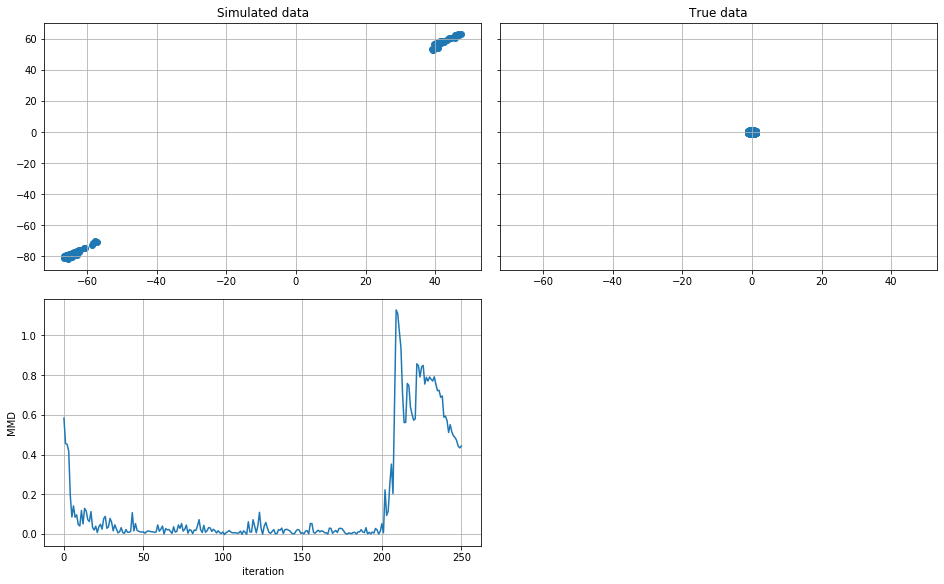

In [61]:
# Trial one
# generate a data set from a Gaussian Mixture
N = 1000

# set seed
np.random.seed(seed=48514)
y, y_label = make_circles(n_samples=N,noise=0.1)
# compute bandwidth to use
distMat = cdist(torch.from_numpy(y),torch.from_numpy(y))
distMat = 0.5*(distMat**2)
sigma = np.sqrt(np.median(distMat.numpy()))


# set up initial weights and biases (choose them randomly)
np.random.seed(seed=7881)
w_init = []
w_init.append(norm.rvs(size=(10,4)))
w_init.append(norm.rvs(size=(4,10)))
b_init = []
b_init.append(norm.rvs(size=(10,1)))
b_init.append(norm.rvs(size=(4,1)))

n_sim = 100
step = 0.25
n_iter = 250
sigma_1 = 0.5
sigma_2 = 0.5
sigma_3 = 0.5
sigma_4 = 0.5
t = np.linspace(0,2,20)

np.random.seed(seed=54151)
torch.manual_seed(4841)
w_hat, b_hat, MMD_est = adjoint_grad_descent(y,t,sigma_1,sigma_2,sigma_3,sigma_4,sigma,w_init,b_init,n_sim,step_size=step,N_iter=n_iter)


In [62]:
# get parameters which obtained lowest score
w = w_hat[MMD_est.argmin()]
b = b_hat[MMD_est.argmin()]

In [63]:
# lowest score
MMD_est.min()

In [64]:
n_samples = 1000
dat = noisyNeural(n_samples,sigma_1,sigma_2,sigma_3,sigma_4,t,w,b)
dat = np.stack(dat)
        
# extract the observations from simulations (first component at final time)
x = dat[:,-1,0:2]

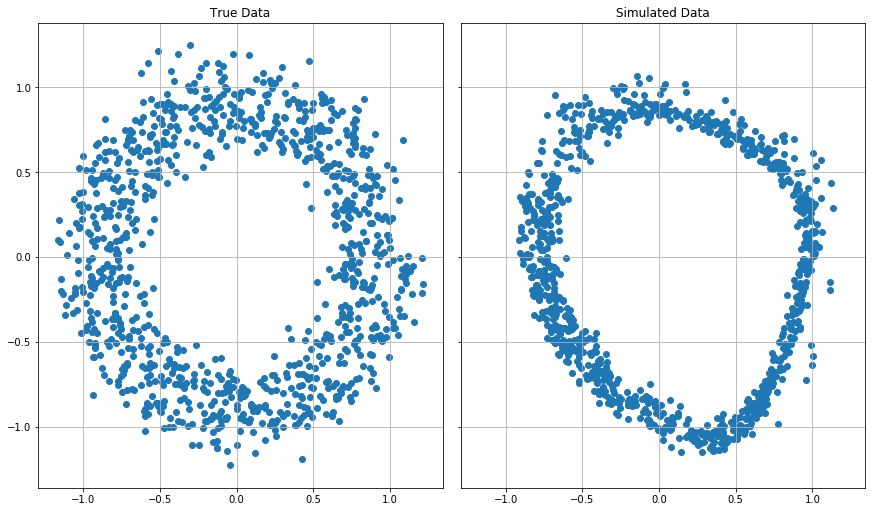

In [69]:
fig, (ax1,ax2) = plt.subplots(1,2,constrained_layout=True,figsize=(12,7),sharey = True,sharex=True)
ax1.scatter(y.reshape(N,-1)[:,0],y.reshape(N,-1)[:,1])
ax1.grid()
ax1.set_title('True Data')
ax2.scatter(x[:,0],x[:,1])
ax2.grid()
ax2.set_title('Simulated Data')
plt.show()

In [70]:
## code to save results
# import pickle
# with open('circles_w_1','wb') as f:
#     pickle.dump(w_hat, f)
# with open('circles_b_1','wb') as f:
#     pickle.dump(b_hat, f)
    
# np.save('MMD_est_circles_1.npy',MMD_est)